# Guided Project: Analyzing CIA Factbook Data Using SQL

In this project, we'll work with data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like the following:

- population — the global population
- population_growth — the annual population growth rate, as a percentage
- area — the total land and water area

In this guided project, we'll use SQL in Jupyter Notebook to analyze data from this database. If you want to work with this data, you can download the [SQLite factbook.db database](https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db).

## Setup

This cell connects us to our database

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

## Overview of the Data

Let's begin by taking a look at the tables we've been provided.

In [2]:
%%sql
SELECT *
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


Let's review the facts table

In [3]:
%%sql
SELECT *
  FROM facts
 LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:

- name — the name of the country.
- area — the total land and sea area of the country.
- population — the country's population.
- population_growth — the country's population growth as a percentage.
- birth_rate — the country's birth rate, or the number of births a year per 1,000 people.
- death_rate — the country's death rate, or the number of death a year per 1,000 people.
- area — the country's total area (both land and water).
- area_land — the country's land area in square kilometers.
- area_water — the country's water area in square kilometers.

## Summary Statistics

Let's calculate some summary statistics and see what they tell us

In [4]:
%%sql
SELECT MIN(population) AS minimum_population,
       MAX(population) AS maximum_population,
       MIN(population_growth) AS minimum_population_growth,
       MAX(population_growth) AS maximum_population_growth
  FROM facts;

 * sqlite:///factbook.db
Done.


minimum_population,maximum_population,minimum_population_growth,maximum_population_growth
0,7256490011,0.0,4.02


A few things are interesting in the summary statistics on the previous screen:

- There's a country with a population of `0`
- There's a country with a population of `7256490011` (or more than 7.2 billion people)

Let's use subqueries to concentrate on these countries without using the specific values

## Exploring Outliers

### minimum_population

Let's look into that country with a population of 0 first

In [5]:
%%sql
SELECT *
  FROM facts
 WHERE population = (SELECT MIN(population)
                       FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


It seems like the table contains a row for Antarctica, which explains the population of 0. This seems to match the CIA Factbook [page for Antarctica](https://www.cia.gov/the-world-factbook/countries/antarctica/)

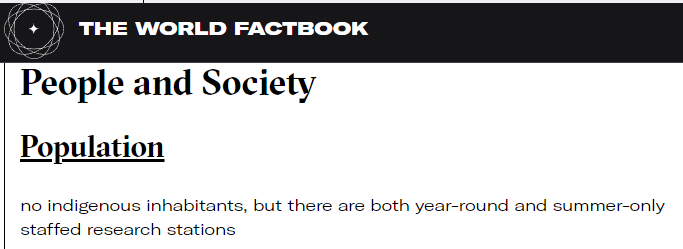

### maximum_population

The minimum population "country" ended up being explainable, what about the maximum population country?

In [6]:
%%sql
SELECT *
  FROM facts
 WHERE population = (SELECT MAX(population)
                       FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Once again we've found a non-country row, this time representing the entire world

This explains the maximum population of over 7.2 billion we found earlier

Now that we know this, we should recalculate the summary statistics we calculated earlier, while excluding the row for the whole word.

## Summary Statistics Revisited

In [7]:
%%sql
SELECT MIN(population) AS minimum_population,
       MAX(population) AS maximum_population,
       MIN(population_growth) AS minimum_population_growth,
       MAX(population_growth) AS maximum_population_growth
  FROM facts
 WHERE name != 'World';

 * sqlite:///factbook.db
Done.


minimum_population,maximum_population,minimum_population_growth,maximum_population_growth
0,1367485388,0.0,4.02


## Exploring Average Population and Area

Let's explore density next

Density depends on the population and the country's area

Let's look at the average values for these two columns

We should remember to ignore the row for the whole planet

In [8]:
%%sql
SELECT AVG(population) AS average_population,
       AVG(area) AS average_area
  FROM facts
 WHERE name != 'World';

 * sqlite:///factbook.db
Done.


average_population,average_area
32242666.56846473,555093.546184739


We see that the average population is around 32 million and the average area is 555 thousand square kilometers

## Finding Densely Populated Countries

To finish, we'll build on the query above to find countries that are densely populated. We'll identify countries that have the following:

- Above-average values for population
- Below-average values for area

In [9]:
%%sql
SELECT *
  FROM facts
 WHERE population > (SELECT AVG(population)
                       FROM facts
                      WHERE name != 'World')
   AND area < (SELECT AVG(area)
                 FROM facts
                WHERE name != 'World')
 ORDER BY (population * 1.0) / area DESC;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.0
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
192,vm,Vietnam,331210,310070,21140,94348835,0.97,15.96,5.93,0.3
185,uk,United Kingdom,243610,241930,1680,64088222,0.54,12.17,9.35,2.54
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.1
182,ug,Uganda,241038,197100,43938,37101745,3.24,43.79,10.69,0.74
173,th,Thailand,513120,510890,2230,67976405,0.34,11.19,7.8,0.0


## Additional Questions

Which country has the most people?

In [10]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
 ORDER BY population DESC
 LIMIT 1;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44


Which country has the highest growth rate?

In [11]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
 ORDER BY population_growth DESC
 LIMIT 1;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
162,od,South Sudan,644329,None,None,12042910,4.02,36.91,8.18,11.47


South Sudan doesn't have a correct value for area_land or area_water

We should remember that for later

Which countries have the highest ratios of water to land?

In [12]:
%%sql
SELECT *, ROUND((area_water + 0.0) / area_land, 2) AS ratio_of_water_to_land
  FROM facts
 WHERE name != 'World'
 ORDER BY (area_water + 0.0) / area_land DESC
 LIMIT 10;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,ratio_of_water_to_land
228,io,British Indian Ocean Territory,54400,60,54340,None,None,None,None,None,905.67
247,vq,Virgin Islands,1910,346,1564,103574,0.59,10.31,8.54,7.67,4.52
246,rq,Puerto Rico,13791,8870,4921,3598357,0.6,10.86,8.67,8.15,0.55
12,bf,"Bahamas, The",13880,10010,3870,324597,0.85,15.5,7.05,0.0,0.39
71,pu,Guinea-Bissau,36125,28120,8005,1726170,1.91,33.38,14.33,0.0,0.28
106,mi,Malawi,118484,94080,24404,17964697,3.32,41.56,8.41,0.0,0.26
125,nl,Netherlands,41543,33893,7650,16947904,0.41,10.83,8.66,1.95,0.23
182,ug,Uganda,241038,197100,43938,37101745,3.24,43.79,10.69,0.74,0.22
56,er,Eritrea,117600,101000,16600,6527689,2.25,30.0,7.52,0.0,0.16
99,li,Liberia,111369,96320,15049,4195666,2.47,34.41,9.69,0.0,0.16


Which countries have more water than land?

In [13]:
%%sql
SELECT *, area_water - area_land AS water_land_diff
  FROM facts
 WHERE name != 'World'
   AND area_water > area_land
 ORDER BY area_water / area_land DESC;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,water_land_diff
228,io,British Indian Ocean Territory,54400,60,54340,None,None,None,None,None,54280
247,vq,Virgin Islands,1910,346,1564,103574,0.59,10.31,8.54,7.67,1218


We know that there are rows without area_land and area_water values, let's at least surface those

If need be we can have an intern go evalute those rows by hand

Which rows can we not effectively evaluate land and water area of?

In [14]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
   AND (area_water IS NULL OR area_land IS NULL)
 ORDER BY area_water DESC, area_land DESC;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
58,et,Ethiopia,1104300,None,104300,99465819,2.89,37.27,8.19,0.22
207,gl,Greenland,2166086,2166086,None,57733,0.0,14.48,8.49,5.98
250,ay,Antarctica,None,280000,None,0,None,None,None,None
126,nz,New Zealand,267710,267710,None,4438393,0.82,13.33,7.36,2.21
213,rn,Saint Martin,54,54,None,31754,None,None,None,None
162,od,South Sudan,644329,None,None,12042910,4.02,36.91,8.18,11.47
165,su,Sudan,1861484,None,None,36108853,1.72,29.19,7.66,4.29
197,ee,European Union,4324782,None,None,513949445,0.25,10.2,10.2,2.5
210,fs,French Southern and Antarctic Lands,None,None,None,None,None,None,None,None
212,tb,Saint Barthelemy,None,None,None,7237,None,None,None,None


Which countries will add the most people to their populations next year?

In [15]:
%%sql
SELECT *, CAST(ROUND(population * (population_growth / 100)) AS INT) AS est_population_increase
  FROM facts
 WHERE name != 'World'
 ORDER BY population * (population_growth / 100) DESC
 LIMIT 10;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,est_population_increase
77,in,India,3287263,2973193,314070,1251695584,1.22,19.55,7.32,0.04,15270686
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44,6153684
129,ni,Nigeria,923768,910768,13000,181562056,2.45,37.64,12.9,0.22,4448270
132,pk,Pakistan,796095,770875,25220,199085847,1.46,22.58,6.49,1.54,2906653
58,et,Ethiopia,1104300,None,104300,99465819,2.89,37.27,8.19,0.22,2874562
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46,2703324
186,us,United States,9826675,9161966,664709,321368864,0.78,12.49,8.15,3.86,2506677
78,id,Indonesia,1904569,1811569,93000,255993674,0.92,16.72,6.37,1.16,2355142
40,cg,"Congo, Democratic Republic of the",2344858,2267048,77810,79375136,2.45,34.88,10.07,0.27,1944691
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09,1626074


Which countries have a higher death rate than birth rate?

In [16]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
   AND death_rate > birth_rate
 ORDER BY death_rate / birth_rate DESC;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
26,bu,Bulgaria,110879,108489,2390,7186893,0.58,8.92,14.44,0.29
153,ri,Serbia,77474,77474,0,7176794,0.46,9.08,13.66,0.0
96,lg,Latvia,64589,62249,2340,1986705,1.06,10.0,14.31,6.26
102,lh,Lithuania,65300,62680,2620,2884433,1.04,10.1,14.27,6.27
75,hu,Hungary,93028,89608,3420,9897541,0.22,9.16,12.73,1.33
117,mn,Monaco,2,2,0,30535,0.12,6.65,9.24,3.83
158,si,Slovenia,20273,20151,122,1983412,0.26,8.42,11.37,0.37
183,up,Ukraine,603550,579330,24220,44429471,0.6,10.72,14.46,2.25
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
214,sb,Saint Pierre and Miquelon,242,242,0,5657,1.08,7.42,9.72,8.49


Which countries have the highest population/area ratio?

In [17]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
 ORDER BY (population * 1.0) / area DESC
 LIMIT 20;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
205,mc,Macau,28,28,0,592731,0.8,8.88,4.22,3.37
117,mn,Monaco,2,2,0,30535,0.12,6.65,9.24,3.83
156,sn,Singapore,697,687,10,5674472,1.89,8.27,3.43,14.05
204,hk,Hong Kong,1108,1073,35,7141106,0.38,9.23,7.07,1.68
251,gz,Gaza Strip,360,360,0,1869055,2.81,31.11,3.04,0.0
233,gi,Gibraltar,6,6,0,29258,0.24,14.08,8.37,3.28
13,ba,Bahrain,760,760,0,1346613,2.41,13.66,2.69,13.09
108,mv,Maldives,298,298,0,393253,0.08,15.75,3.89,12.68
110,mt,Malta,316,316,0,413965,0.31,10.18,9.09,1.98
227,bd,Bermuda,54,54,0,70196,0.5,11.33,8.23,1.88


Once again, I bet we're missing the data to evaluate the population density for some rows

Let's surface those rows and give them some order to make it easier for our intern to evaluate by hand

In [18]:
%%sql
SELECT *
  FROM facts
 WHERE name != 'World'
   AND (population IS NULL OR area IS NULL)
 ORDER BY population DESC, area DESC;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
128,ng,Niger,None,1266700,300,18045729,3.25,45.45,12.42,0.56
35,cd,Chad,None,1259200,24800,11631456,1.89,36.6,14.28,3.45
212,tb,Saint Barthelemy,None,None,None,7237,None,None,None,None
250,ay,Antarctica,None,280000,None,0,None,None,None,None
228,io,British Indian Ocean Territory,54400,60,54340,None,None,None,None,None
240,sx,South Georgia and South Sandwich Islands,3903,3903,0,None,None,None,None,None
202,hm,Heard Island and McDonald Islands,412,412,0,None,None,None,None,None
223,jn,Jan Mayen,377,377,0,None,None,None,None,None
222,bv,Bouvet Island,49,49,0,None,None,None,None,None
252,pf,Paracel Islands,7,7,0,None,None,None,None,None
